# Task 2

In [27]:
# importing important modules
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm, trange
from matplotlib.animation import FuncAnimation
# copy
from copy import deepcopy as copy

def make_gif(x, us, name, labels, skip_frame = 1, till=None, fps=25):
    us = us[:, :till:skip_frame, :] if till is not None else us[:, ::skip_frame, :]
    max_B = np.max(us)
    min_B = np.min(us)

    p = tqdm(total=us.shape[1]+1)

    fig, ax = plt.subplots()
    def update(frame):
        p.update(1)
        ax.clear()
        colours = [
            'tab:blue',
            'tab:orange',
        ]

        ax.plot(x, us[0, 0], colours[0], label=f"Initial {labels[0]}", alpha=0.4, linestyle="--")
        ax.plot(x, us[0, frame], colours[0], label=labels[0])
        
        ax.plot(x, us[1, 0], colours[1], label=f"Initial {labels[1]}", alpha=0.4, linestyle="--")
        ax.plot(x, us[1, frame], colours[1], label=labels[1])
        plt.ylim(min_B, max_B)
        ax.set_title(f"Magnetic Field Strength vs z Distance at Time Step {frame*skip_frame}")
        ax.set_xlabel('Distance (z)')
        ax.set_ylabel('Magnetic Field Strength (B)')
        ax.legend(loc='lower right')
        ax.grid()

    animation = FuncAnimation(fig, update, frames=us.shape[1], interval=int(1000/fps), repeat=False)
    animation.save(f"outputs/asgt2/{name}", writer='imagemagick')
    p.close()

## Equations to solve:

$$ \frac{\partial B_r}{\partial t} = - \frac{\partial}{\partial z} (\alpha B_\phi) + \frac{\partial^2 B_r}{\partial z^2} $$

$$ \frac{\partial B_\phi}{\partial t} = DS B_r + \frac{\partial^2 B_\phi}{\partial z^2} $$

Here I am supposed to solve the above equations in varying $z$ and $t$, keeping $r$ constant. Thus the $\alpha$, $D$ and $S$ are constants.

$$ \frac{\partial B_r}{\partial t} = -\alpha  \frac{\partial B_\phi}{\partial z} + \frac{\partial^2 B_r}{\partial z^2} $$

$$ \frac{\partial B_\phi}{\partial t} = DS B_r + \frac{\partial^2 B_\phi}{\partial z^2} $$

<!-- ## Trial 1: Finite Difference Method

In this case we can take:

$$\frac{\partial U}{\partial x} = \frac{U_{n} - U_{n-1}}{\Delta x}$$
$$\frac{\partial^2 U}{\partial x^2} = \frac{U_{n+1} - 2U_{n} + U_{n-1}}{\Delta x^2}$$

Thus the equations become (taking $B_r$ as $U$ and $B_\phi$ as $V$, and let i be the spatial index and j be the time index):

$$ \frac{U_{i,j} - U_{i,j-1}}{\Delta t} = -\alpha \frac{V_{i,j-1} - V_{i-1,j-1}}{\Delta z} + \frac{U_{i+1,j-1} - 2U_{i,j-1} + U_{i-1,j-1}}{\Delta z^2} $$
$$ \frac{V_{i,j} - V_{i,j-1}}{\Delta t} = DS U_{i,j-1} + \frac{V_{i+1,j-1} - 2V_{i,j-1} + V_{i-1,j-1}}{\Delta z^2} $$

keeping all the $j$ terms on the left side and all the $j-1$ terms on the right side:

$$ U_{i,j} = U_{i,j-1} - \frac{\alpha \Delta t}{\Delta z} (V_{i,j-1} - V_{i-1,j-1}) + \frac{\Delta t}{\Delta z^2} (U_{i+1,j-1} - 2U_{i,j-1} + U_{i-1,j-1}) $$
$$ V_{i,j} = V_{i,j-1} DS \Delta t U_{i,j-1} + \frac{\Delta t}{\Delta z^2} (V_{i+1,j-1} - 2V_{i,j-1} + V_{i-1,j-1}) $$ -->

## Crank Nicolson Method:

In this case we can take:

$$\frac{\partial U}{\partial x} = \frac{U_{i, j-1} - U_{i-1, j-1}}{\Delta x}$$
$$\frac{\partial^2 U}{\partial x^2} = \frac{1}{2\Delta x^2} \left[ (U_{i-1, j-1} + U_{i+1, j-1} - 2U_{i, j-1}) + (U_{i-1, j} + U_{i+1, j} - 2U_{i, j}) \right]$$

In the double difference term, we take the average of the two time steps.

Thus putting these in the equations:

$$ \frac{U_{i,j} - U_{i,j-1}}{\Delta t} = -\alpha \frac{V_{i,j-1} - V_{i-1,j-1}}{\Delta z} + \frac{1}{2\Delta z^2} \left[ (U_{i-1,j-1} + U_{i+1,j-1} - 2U_{i,j-1}) + (U_{i-1,j} + U_{i+1,j} - 2U_{i,j}) \right] $$

$$ \frac{V_{i,j} - V_{i,j-1}}{\Delta t} = DS U_{i,j} + \frac{1}{2\Delta z^2} \left[ (V_{i-1,j-1} + V_{i+1,j-1} - 2V_{i,j-1}) + (V_{i-1,j} + V_{i+1,j} - 2V_{i,j}) \right] $$

Now, keeping all the $j$ terms on the left side and all the $j-1$ terms on the right side:

$$ U_{i,j} (\frac{1}{\Delta t} + \frac{1}{2\Delta z^2}) - (U_{i-1,j} + U_{i+1,j}) \frac{1}{2\Delta z^2} = U_{i,j-1} (\frac{1}{\Delta t} - \frac{1}{\Delta z^2}) - \alpha \frac{V_{i,j-1} - V_{i-1,j-1}}{\Delta z} + \frac{1}{2\Delta z^2} (U_{i-1,j-1} + U_{i+1,j-1})$$

--- (1)

$$ V_{i,j} (\frac{1}{\Delta t} + \frac{1}{2\Delta z^2}) - (V_{i-1,j} + V_{i+1,j}) \frac{1}{2\Delta z^2} = V_{i,j-1} (\frac{1}{\Delta t} - \frac{1}{\Delta z^2}) + DS U_{i,j} + \frac{1}{2\Delta z^2} (V_{i-1,j-1} + V_{i+1,j-1})$$

--- (2)

Here to find $U_{i, j}$ we need all the values of $U$ and $V$ at time step $j-1$ (which is not a problem) along with $U_{i-1, j}$ and $V_{i-1, j}$ at time step $j$ (which is a problem). We don't have these values yet. Thus we need to construct a set of linear equations to solve this problem. Similar thing is applied to $V$ too.

Now, let us say $a = (\frac{1}{\Delta t} - \frac{1}{2\Delta z^2})$, $b = \frac{1}{2\Delta z^2}$ and $c_i = U_{i,j-1} (\frac{1}{\Delta t} - \frac{1}{\Delta z^2}) - \alpha \frac{V_{i,j-1} - V_{i-1,j-1}}{\Delta z} + \frac{1}{2\Delta z^2} (U_{i-1,j-1} + U_{i+1,j-1})$ the whole left side of equation 1 (which is known). Thus we can make a matrix linear equation like $Ax=B$ where we need to get $X$ as the solution. And A and B are of the form:

$$ A = \begin{bmatrix}
 a & -b &  0 &  0 & 0 \\
-b &  a & -b &  0 & 0 \\
 0 & -b &  a & -b & 0 \\
 0 &  0 & -b &  a & -b \\
 0 &  0 &  0 & -b &  a \\
\end{bmatrix} $$

$$ B = \begin{bmatrix}
c_1 \\
c_2 \\
c_3 \\
c_4 \\
c_5 \\
\end{bmatrix} $$

Thus for every time step we need to solve this matrix equation to get the values of $U$ and $V$ at that time step.

**I haven't shown the matrix for calculating $V$ but that will be similar, only the formula for $c_i$ would change**

In [2]:
def solve(U, V, dt, dx, alpha0, omega, q=1, eta = 1, verbose = True):
    assert U.shape == V.shape, "U and V must have the same shape/resolution"
    U = copy(U)  # copy to avoid changing the original
    V = copy(V)  # copy to avoid changing the original
    # if verbose: print(f"U shape: {U.shape}, V shape: {V.shape}")
    a = 1/dt + eta/(dx**2)
    b = eta/(2*dx**2)
    if verbose:
        print(f"Dynamo number = {alpha0*q*omega*1/eta**3}")
        # print(f"a: {a}, b: {b}")

    A = np.zeros((U.shape[1]-2, U.shape[1]-2))
    for row in range(A.shape[0]):
        A[row, row] = a
        if row > 0:
            A[row, row-1] = -b
        if row < A.shape[0]-1:
            A[row, row+1] = -b

    A_inv = np.linalg.inv(A)

    if verbose: ra = trange
    else: ra = range
    
    z = np.linspace(-1, 1, U.shape[1]-1)
    # alpha = -alpha0 if z < 0, 0 if z = 0, +alpha0 if z>0
    # alpha =

    for j in ra(1, U.shape[0]):  # for all the time steps
        # make B for U
        BU = np.zeros(U.shape[1]-2)
        # BU = U_{i,j-1} (\frac{1}{\Delta t} - \frac{1}{\Delta z^2}) - \alpha \frac{V_{i,j-1} - V_{i-1,j-1}}{\Delta z} + \frac{1}{2\Delta z^2} (U_{i-1,j-1} + U_{i+1,j-1})
        for i, zi in enumerate(z):
            BU[i-1] = U[j-1, i]*(1/dt - eta/dx**2) - alpha0*np.sign(zi)*(V[j-1, i] - V[j-1, i-1])/dx + b*(U[j-1, i-1] + U[j-1, i+1])
        # solve for U
        U[j, 1:-1] = A_inv @ BU

        BV = np.zeros(V.shape[1]-2)
        # BV = V_{i,j-1} (\frac{1}{\Delta t} - \frac{1}{\Delta z^2}) + DS U_{i,j} + \frac{1}{2\Delta z^2} (V_{i-1,j-1} + V_{i+1,j-1})
        for i in range(1, V.shape[1]-1):
            BV[i-1] = V[j-1, i]*(1/dt - eta/dx**2) - omega*q*U[j, i] + b*(V[j-1, i-1] + V[j-1, i+1])
        # solve for V
        V[j, 1:-1] = A_inv @ BV.T
    
    return U, V

## Repeat the investigation you had done for task 1, with the new equations, for different values of the dynamo number.

Dynamo number = -8.0


100%|██████████| 126/126 [00:51<00:00,  2.44it/s]


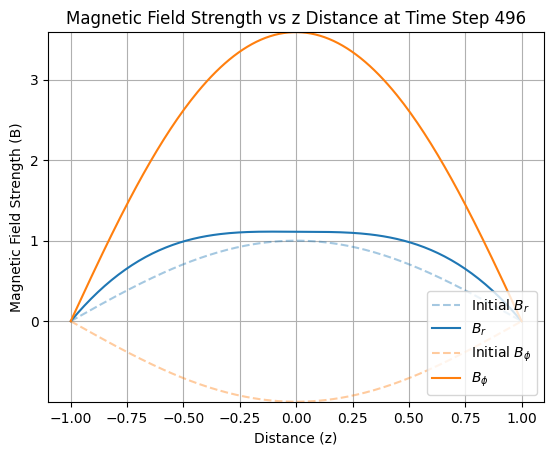

In [28]:
# Defining Grid and Initial Conditions
T = 5
dT = 0.01
NT = int(T/dT)
L = 2
dL = 0.01
NL = int(L/dL)
U = np.zeros((NT, NL))  # Initialize U matrix
V = np.zeros((NT, NL))  # Initialize V matrix

U[0, :] = np.sin(np.linspace(0, np.pi, NL))  # Set the first row of U to sin(x)
V[0, :] = -np.sin(np.linspace(0, np.pi, NL))

U, V = solve(U, V, dT, dL, alpha0=1, omega = 8, q = -1, eta = 1)
make_gif(np.linspace(-L/2, L/2, NL), np.array([U, V]), "growing_dynamo.gif", labels=["$B_r$", "$B_\phi$"], skip_frame=4, till=None, fps=24)

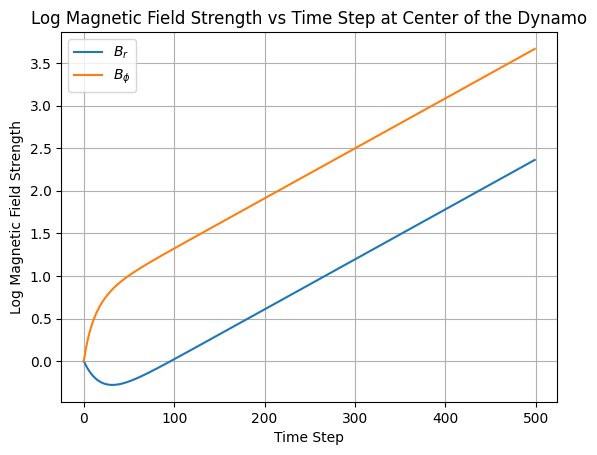

In [22]:
i = int(L/(2*dL))
plt.plot(np.log(np.abs(U[:, int(L/(2*dL))])), label = "$B_r$")
plt.plot(np.log(np.abs(V[:, int(L/(2*dL))])), label = "$B_\phi$")

plt.grid()
plt.xlabel("Time Step")
plt.ylabel("Log Magnetic Field Strength")
plt.title("Log Magnetic Field Strength vs Time Step at Center of the Dynamo")
plt.legend()

plt.savefig("outputs/asgt2/growing_dynamo_log_plot.png")

We can see that for Dynamo number $D = -7$ we get a growing dynamo. The gif is shown below:

![growing_dynamo.gif](outputs/asgt2/growing_dynamo.gif)

And here is the plot of the log of the magnetic field with respect to time at the center of the space:

![growing_dynamo.png](outputs/asgt2/growing_dynamo_log_plot.png)

In [ ]:
# Defining Grid and Initial Conditions
T = 5
dT = 0.01
NT = int(T/dT)
L = 2
dL = 0.01
NL = int(L/dL)
U = np.zeros((NT, NL))  # Initialize U matrix
V = np.zeros((NT, NL))  # Initialize V matrix

U[0, :] = np.sin(np.linspace(0, 1*np.pi, NL))  # Set the first row of U to sin(x)
V[0, :] = np.sin(np.linspace(0, 1*np.pi, NL))

U, V = solve(U, V, dT, dL, alpha0=1, omega = 6, q = -1, eta = 1)
make_gif(np.linspace(-L/2, L/2, NL), np.array([U, V]), "decaying_dynamo.gif", labels=["$B_r$", "$B_\phi$"], skip_frame=4, till=None, fps=24)

In [ ]:
i = int(L/(2*dL))
plt.plot(np.log(np.abs(U[:, int(L/(2*dL))])), label = "$B_r$")
plt.plot(np.log(np.abs(V[:, int(L/(2*dL))])), label = "$B_\phi$")

plt.grid()
plt.xlabel("Time Step")
plt.ylabel("Log Magnetic Field Strength")
plt.title("Log Magnetic Field Strength vs Time Step at Center of the Dynamo")
plt.legend()

plt.savefig("outputs/asgt2/decaying_dynamo_log_plot.png")

We can see that for Dynamo number $D = 0.01$ we get a decaying dynamo. The gif is shown below:

![decaying_dynamo.gif](outputs/asgt2/decaying_dynamo.gif)

## Finding $D_c$

We know that at $D > D_c$ the dynamo grows exponentially and at $D < D_c$ the dynamo decays exponentially. Thus we need to define the notion of growth and decay. Let me define the growth and decay as follows:

In [ ]:
def metric(mat):
    return np.mean(np.sum(np.abs(mat), axis=1))

def growth_rate(U, V):
    U0, V0 = U[0:1, :], V[0:1, :]
    return (metric(U) + metric(V))/ (metric(U0) + metric(V0))

We could have used advanced techniques like **gradient descent** to find the value of $D_c$ but I am going to use a simple technique. I am going to plot the values of `growth_rate` for a range of $D$ values and find the value of $D$ where the `growth_rate` is 1. This is the value of $D_c$.

We have seen that for $D = 0.1$ the dynamo grows and for $D = 0.01$ the dynamo decays. Thus the value of $D_c$ should be between 0.01 and 0.1. Thus I am going to take a range of $D$ values from 0.01 to 0.1 and find the value of $D$ where the `growth_rate` is 1.

In [ ]:
T = 6000  # this I have to keep high
dT = 100
NT = int(T/dT)
L = 100
dL = 1
NL = int(L/dL)
U = np.zeros((NT, NL))
V = np.zeros((NT, NL))
alpha = 0.01
U[0, :] = np.sin(np.linspace(0, 2*np.pi, NL))  # Set the first row of U to sin(x)
V[0, :] = np.cos(np.linspace(0, 4*np.pi, NL) + np.pi/2)

Dlow = 0.01
Dhigh = 0.05  # 1e-1
Ds = np.linspace(Dlow, Dhigh, 1000)
rates = []

for D in tqdm(Ds):
    U, V = solve(U, V, dT, dL, alpha, D=D, verbose=False)
    
    rate = growth_rate(U, V)
    rates.append(rate)
rates = np.array(rates)

In [ ]:
Dc = Ds[(rates < 1).sum()]
plt.plot(Ds, rates, label="Growth Rate")
plt.grid()
plt.axvline(Dc, color='r', linestyle='--', label=f"$D_c = {Dc:.4f}$")
plt.axhline(1, color='g', linestyle='--', label=f"growth rate = 1")
plt.xlabel("D")
plt.ylabel("Growth Rate")
plt.legend()
plt.title("Growth Rate vs Diffusion Constant")
plt.text(Dc, 1, f"$D_c = {Dc:.4f}$", fontsize=12, color='k', ha='left', va='top')
plt.savefig("outputs/asgt2/find_Dc.png")

![find_Dc.png](outputs/asgt2/find_Dc.png)

Simulation of the dynamo at $D = D_c$

In [ ]:
T = 12000
dT = 100
NT = int(T/dT)
L = 100
dL = 1
NL = int(L/dL)
U = np.zeros((NT, NL))
V = np.zeros((NT, NL))
alpha = 1

U[0, :] = np.sin(np.linspace(0, 2*np.pi, NL))  # Set the first row of U to sin(x)
V[0, :] = np.cos(np.linspace(0, 4*np.pi, NL) + np.pi/2)

U, V = solve(U, V, dT, dL, alpha, D=)
make_gif(np.linspace(0, L, NL), np.array([U, V]), "stable_dynamo.gif", labels=["$B_r$", "$B_\phi$"], skip_frame=2, till=None, fps=25)

![stable_dynamo.gif](outputs/asgt2/stable_dynamo.gif)

**Note:** Although the calculated value of the $D_c$ is stable, it fluctuates a lot in our experiment because we chose large values of $\Delta t$ and $\Delta z$ to make the simulation faster. Thus the value of $D_c$ is not stable in our experiment. It converges to the correct value as we decrease the values of $\Delta t$ and $\Delta z$ but the simulation becomes slower. $D_c$ also tends to depend slightly on the value of total time of the simulation, and converges to as the total simulation time grows to infinity (which is practically not possible).